In [1]:
import os
import cv2
import time
import pandas as pd
import numpy as np
from skimage import feature
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [2]:
image = cv2.imread('fer-2013/test/angry/PrivateTest_1623042.jpg', 0)
image.shape

(48, 48)

In [3]:
# Function to read data from folder
def read_data(path: str):
    data_path = []
    labels = []
    for dirname, name, filenames in os.walk('fer-2013/' + path):
        for filename in filenames:
            data_path.append(os.path.join(dirname, filename))
            labels.append(dirname.split('/')[-1])
    return data_path, labels

In [4]:
X_train_path, label_train = read_data('train')
X_test_path, label_test = read_data('test')

In [5]:
df_train = pd.DataFrame(
    {'X_train': X_train_path,
     'y_train' :label_train}
)

In [6]:
df_train.head()

,X_train,y_train
0,fer-2013/train/happy/Training_50449107.jpg,happy
1,fer-2013/train/happy/Training_70433018.jpg,happy
2,fer-2013/train/happy/Training_85610005.jpg,happy
3,fer-2013/train/happy/Training_4460748.jpg,happy
4,fer-2013/train/happy/Training_6312930.jpg,happy


In [7]:
name_train, frequency_train = np.unique(df_train.y_train,return_counts=True)

In [8]:
df_test = pd.DataFrame({
    'X_test':X_test_path,
    'y_test' :label_test}
)

In [9]:
df_test.head()

,X_test,y_test
0,fer-2013/test/happy/PrivateTest_45699463.jpg,happy
1,fer-2013/test/happy/PrivateTest_61855708.jpg,happy
2,fer-2013/test/happy/PublicTest_53681781.jpg,happy
3,fer-2013/test/happy/PrivateTest_52109800.jpg,happy
4,fer-2013/test/happy/PublicTest_41104919.jpg,happy


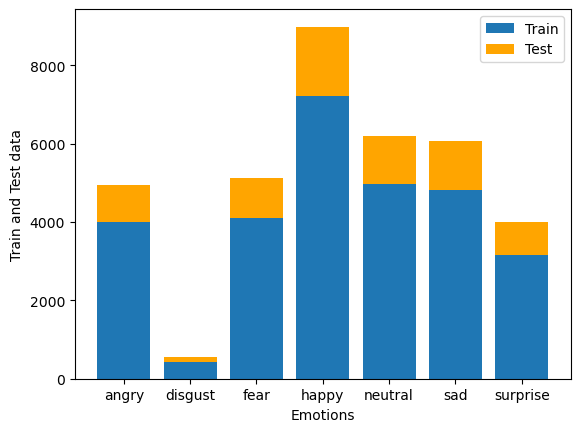

In [10]:
name_test, frequency_test = np.unique(df_test.y_test, return_counts=True)
plt.bar(name_train, frequency_train)
plt.bar(name_test, frequency_test, bottom=frequency_train, color='orange')
plt.xlabel("Emotions")
plt.ylabel("Train and Test data")
plt.legend(["Train", "Test"])

In [11]:
# The above plot shows that the data is unbalanced. The data has many samples for happy but very few for disgust.
# Hence, we need to balance the data.
df_train.y_train.value_counts()

y_train
happy       7215
neutral     4965
sad         4830
fear        4097
angry       3995
surprise    3171
disgust      436
Name: count, dtype: int64

In [12]:
le = preprocessing.LabelEncoder()

In [13]:
def extract_HOG_features(X):
    X_train = []
    for i in X:
        img = cv2.imread(i, 0)
        gauss = img
        X_train.append(feature.hog(gauss, orientations=5, pixels_per_cell=(8, 8),
                        cells_per_block=(4, 4), transform_sqrt=True, block_norm="L2"))
    return X_train

In [14]:
y_train = le.fit_transform(df_train.y_train)
X_train = extract_HOG_features(df_train.X_train)

In [15]:
scaler = MinMaxScaler(feature_range=(0, 1))
X_train = scaler.fit_transform(X_train)

In [16]:
y_test = le.fit_transform(df_test.y_test)
X_test = extract_HOG_features(df_test.X_test)
X_test = scaler.fit_transform(X_test)

In [17]:
X_train[0].shape, X_test[0].shape

((720,), (720,))

In [18]:
models = []
train_accu = []
test_accu = []

def store_results(model, train_acc, test_acc):
    models.append(model)
    train_accu.append(train_acc)
    test_accu.append(test_acc)

def accuracy(model, X, y_true):
    y_pre = model.predict(X)
    return np.sum(y_pre == y_true)/len(y_true)

In [19]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)

In [20]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# Best Parameters for Decision Tree Classifier
param_grid = {'max_depth': [3, 5, 7, 9, 11, 13],
            'criterion': ['gini', 'entropy']}

grid = GridSearchCV(DecisionTreeClassifier(), param_grid, verbose=3)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV 1/5] END .......criterion=gini, max_depth=3;, score=0.317 total time=   4.4s
[CV 2/5] END .......criterion=gini, max_depth=3;, score=0.313 total time=   4.4s
[CV 3/5] END .......criterion=gini, max_depth=3;, score=0.314 total time=   4.5s
[CV 4/5] END .......criterion=gini, max_depth=3;, score=0.311 total time=   4.4s
[CV 5/5] END .......criterion=gini, max_depth=3;, score=0.297 total time=   4.5s
[CV 1/5] END .......criterion=gini, max_depth=5;, score=0.322 total time=   7.1s
[CV 2/5] END .......criterion=gini, max_depth=5;, score=0.315 total time=   7.0s
[CV 3/5] END .......criterion=gini, max_depth=5;, score=0.320 total time=   7.3s
[CV 4/5] END .......criterion=gini, max_depth=5;, score=0.325 total time=   7.1s
[CV 5/5] END .......criterion=gini, max_depth=5;, score=0.307 total time=   7.1s
[CV 1/5] END .......criterion=gini, max_depth=7;, score=0.336 total time=   9.3s


In [ ]:
print(grid.best_params_)
print(grid.best_estimator_)

{'criterion': 'gini', 'max_depth': 7}
DecisionTreeClassifier(max_depth=7)


In [ ]:
accuracy(grid.best_estimator_, X_train, y_train), accuracy(grid.best_estimator_, X_test, y_test)
store_results(grid.best_estimator_, accuracy(grid.best_estimator_, X_train, y_train), accuracy(grid.best_estimator_, X_test, y_test))

(0.3858720261938765, 0.3326831986625801)

In [ ]:
# Best parameter for KNN Classifier
from sklearn.neighbors import KNeighborsClassifier

param_grid = {'n_neighbors': [3, 5, 7, 9, 11, 13],
            'weights': ['uniform', 'distance']}

grid = GridSearchCV(KNeighborsClassifier(), param_grid, verbose=3)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 1/5] END .....algorithm=auto, n_neighbors=3;, score=0.420 total time=   0.8s
[CV 2/5] END .....algorithm=auto, n_neighbors=3;, score=0.427 total time=   0.8s
[CV 3/5] END .....algorithm=auto, n_neighbors=3;, score=0.415 total time=   0.8s
[CV 4/5] END .....algorithm=auto, n_neighbors=3;, score=0.430 total time=   0.8s
[CV 5/5] END .....algorithm=auto, n_neighbors=3;, score=0.424 total time=   0.8s
[CV 1/5] END .....algorithm=auto, n_neighbors=5;, score=0.422 total time=   0.8s
[CV 2/5] END .....algorithm=auto, n_neighbors=5;, score=0.433 total time=   1.0s
[CV 3/5] END .....algorithm=auto, n_neighbors=5;, score=0.429 total time=   1.0s
[CV 4/5] END .....algorithm=auto, n_neighbors=5;, score=0.432 total time=   0.8s
[CV 5/5] END .....algorithm=auto, n_neighbors=5;, score=0.436 total time=   0.8s
[CV 1/5] END .....algorithm=auto, n_neighbors=7;, score=0.424 total time=   0.8s
[CV 2/5] END .....algorithm=auto, n_neighbors=7;

In [ ]:
print(grid.best_params_)
print(grid.best_estimator_)

In [ ]:
accuracy(grid.best_estimator_, X_train, y_train), accuracy(grid.best_estimator_, X_test, y_test)
store_results(grid.best_estimator_, accuracy(grid.best_estimator_, X_train, y_train), accuracy(grid.best_estimator_, X_test, y_test))

In [ ]:
# Best parameter for Random Forest Classifier
param_grid = {'max_depth': [3, 5, 7, 9, 11, 13],
            'criterion': ['gini', 'entropy', 'log_loss']}

grid = GridSearchCV(RandomForestClassifier(), param_grid, verbose=3)
grid.fit(X_train, y_train)

In [ ]:
print(grid.best_params_)
print(grid.best_estimator_)

In [ ]:
accuracy(grid.best_estimator_, X_train, y_train), accuracy(grid.best_estimator_, X_test, y_test)
store_results(grid.best_estimator_, accuracy(grid.best_estimator_, X_train, y_train), accuracy(grid.best_estimator_, X_test, y_test))

In [ ]:
param_grid = {'C': [0.1, 1, 10, 100, 1000],
                'gamma': [1, 0.1, 0.01],
                'kernel': ['rbf']}

grid = GridSearchCV(SVC(), param_grid, refit=True, verbose=3)
grid.fit(X_train, y_train)

In [ ]:
print(grid.best_params_)
print(grid.best_estimator_)

In [ ]:
accuracy(grid.best_estimator_, X_train, y_train), accuracy(grid.best_estimator_, X_test, y_test)
store_results(grid.best_estimator_, accuracy(grid.best_estimator_, X_train, y_train), accuracy(grid.best_estimator_, X_test, y_test))

In [ ]:
result = pd.DataFrame({
    'ML Model': models,
    'Train Accuracy': train_accu,
    'Test Accuracy': test_accu,
})

In [ ]:
result